# Analyze Region 9 - Russian Arctic

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 9 - Russian Arctic.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "9"
region_name = "Russian Arctic"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # This was not already set in GLIMS so this is my guess at the classification

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 8
region_index_2 = 9

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '5940'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

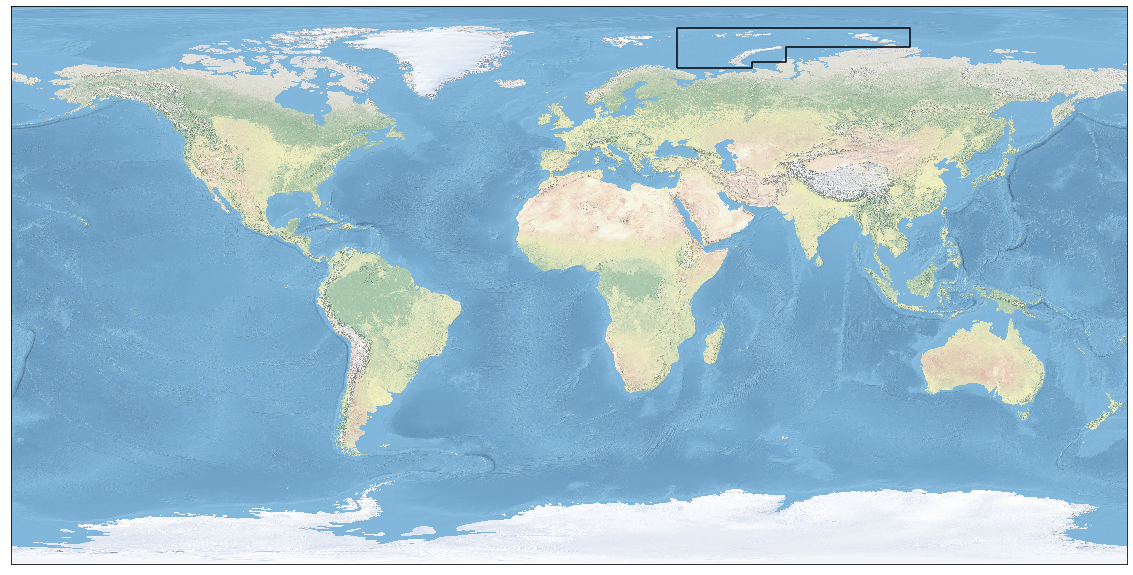

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
8,35.0,70.0,110.0,83.0


# * * * * * * * * Glacier Analysis * * * * * * * *

The glaciers are on Severny Island (large, banana shaped island) in Novaya Zemlya (archipelago northwest of Russia) and Komsomolets Island in Severnaya Zemlya (archipelago northeast of Russia)

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,9,G062382E75725N,1255.770,1256.770,0.0,0.0,0.0,6.0,583.0,909.0,2013-08-19T00:00:00,Severny Island Ice Cap (Severny Island),"POLYGON Z ((62.366901 75.914914 0, 62.369041 7..."
1,9,G094346E80731N,1243.330,1243.500,0.0,0.0,0.0,0.0,0.0,0.0,2006-07-13T00:00:00,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON Z ((97.133342 80.648343 0, 97.087396 8..."
2,9,G093532E80531N,1032.800,1032.800,0.0,0.0,0.0,0.0,0.0,0.0,2006-07-13T00:00:00,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON Z ((94.887281 80.58498899999999 0, 94...."
3,9,G059699E75391N,907.749,908.349,0.0,0.0,0.0,2.0,638.0,981.0,2013-08-03T00:00:00,Severny Island Ice Cap (Severny Island),"POLYGON Z ((60.711513 75.44164600000001 0, 60...."
4,9,G063849E75923N,840.852,841.507,0.0,0.0,0.0,1.0,532.0,877.0,2013-08-19T00:00:00,Severny Island Ice Cap (Severny Island),"POLYGON Z ((64.309765 76.07046699999999 0, 64...."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-09.00116,G060168E75349N,20000812,20080626,60.1675,75.3486,9,2,1412.730,43,...,133,55777,0,0,0,1,1,9,Vylki + Shury,"POLYGON ((60.25392142200008 75.57679367300005,..."
1,RGI60-09.00918,G095292E80735N,20020605,20100821,95.2917,80.7352,9,3,1243.510,18,...,7,26919,0,0,0,0,9,9,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON ((97.13334173000004 80.64834308600007,..."
2,RGI60-09.00969,G093532E80531N,20020605,20100821,93.5319,80.5308,9,3,1032.805,1,...,277,30137,0,0,0,1,9,9,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON ((94.88728057000009 80.58498948900007,..."
3,RGI60-09.00065,G062380E75725N,20000812,20080626,62.3796,75.7252,9,2,957.197,63,...,144,57101,0,0,1,1,1,9,Moshchnyy,"POLYGON ((62.44874871700006 75.89118618400005,..."
4,RGI60-09.00920,G096002E80452N,20020605,20100821,96.0020,80.4523,9,3,829.413,0,...,104,31780,0,0,1,1,9,9,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON ((97.05259920800006 80.52489718300006,..."


## Plot GLIMS Glaciers

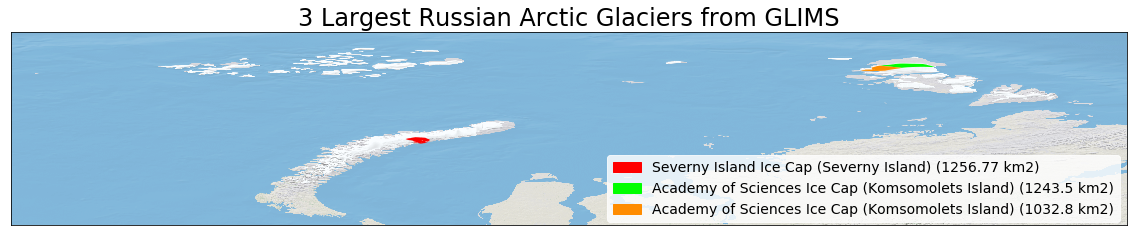

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

## Plot RGI Glaciers

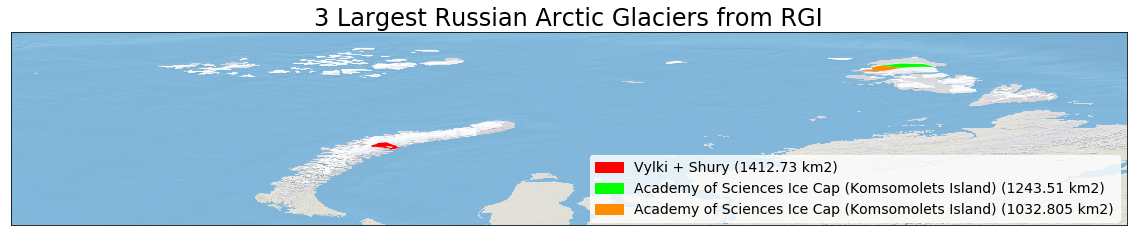

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

The names of glaciers in this region seem to be not well defined. From some literature, I've come up with the following possible glacier names

* G062382E75725N (Severny Island Ice Cap (Severny Island)) = Moshnyj Glacier (Carr, 2014)
* G094346E80731N (Academy of Sciences Ice Cap (Komsomolets Island)) = Academy of Sciences Ice Cap Basin North Glacier (Sánchez-Gámez, 2019)
* G093532E80531N (Academy of Sciences Ice Cap (Komsomolets Island) = Academy of Sciences Ice Cap Basin West Glacier (Sánchez-Gámez, 2019)

Note: Moshnyj Glacier in RGI is smaller than in GLIMS so it doesn't make the top 3 in RGI. The GLIMS one is the newest date so going with that.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glac_id', 
                               'primeclass', 'db_area', 'src_date', 'geometry']]

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

In [17]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    # The largest glacier in RGI doesn't match GLIMS and after a little research going to go with GLIMS,
    # so need to skip the the first entry of GLIMS and RGI and just check the dates of the 2nd and 3rd largest
    if x == 0:
        area = glims_glaciers_df['db_area'][x]
    else:    
        if glims_year == rgi_year:
            # Average GLIMS and RGI areas
            area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
            print('Averaging area: ' + str(area))
        elif glims_year > rgi_year:
            # Use GLIMS area for the area
            area = glims_glaciers_df['db_area'][x]
            print('Using GLIMS area: ' + str(area))
        elif rgi_year > glims_year:
            # Use RGI area for the area
            area = rgi_glaciers_df['Area'][x]
            print('Using RGI area: ' + str(area))
        else:
            print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
    # Use the glacier names from the literature for this region
    if x == 0:
        # Set this name per Carr (2014)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Moshnyj Glacier"
    if x == 1:
        # Set this name per Sánchez-Gámez (2019)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        "Academy of Sciences Ice Cap Basin North Glacier"
    if x == 2:
        # Set this name per Sánchez-Gámez (2019)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        "Academy of Sciences Ice Cap Basin West Glacier"

glims date: 20130819
rgi date: 20000812

glims date: 20060713
rgi date: 20020605
Using GLIMS area: 1243.5

glims date: 20060713
rgi date: 20020605
Using GLIMS area: 1032.8



In [18]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,primeclass,area_km2,date,geometry
0,9,Russian Arctic,Moshnyj Glacier,G062382E75725N,4,1256.77,2013-08-19,"POLYGON Z ((62.366901 75.914914 0, 62.369041 7..."
1,9,Russian Arctic,Academy of Sciences Ice Cap Basin North Glacier,G094346E80731N,4,1243.50,2006-07-13,"POLYGON Z ((97.133342 80.648343 0, 97.087396 8..."
2,9,Russian Arctic,Academy of Sciences Ice Cap Basin West Glacier,G093532E80531N,4,1032.80,2006-07-13,"POLYGON Z ((94.887281 80.58498899999999 0, 94...."


### Plot final glacier dataframe to check accuracy

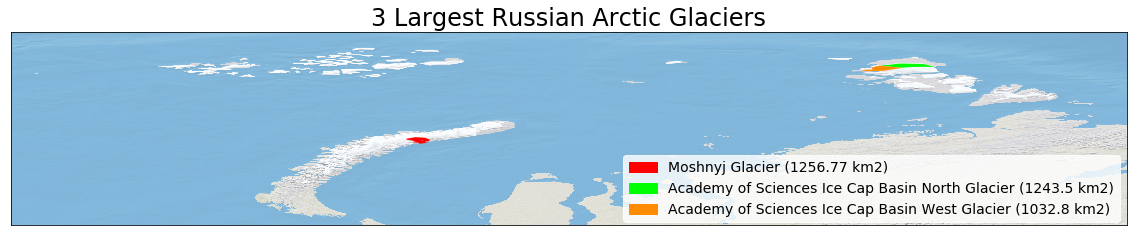

In [19]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [20]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

data/final-dataset/region-9-largest-glaciers.zip already extists


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [21]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_epsg" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [22]:
ice_caps_ex_df

,id,area,geometry
0,90,21072.123177,"POLYGON ((56.918251 74.913927, 56.916186 74.91..."
1,1278,5583.439404,"POLYGON ((94.513183 80.150367, 94.504973000000..."
2,1017,4054.455204,"POLYGON ((99.511706 78.849071, 99.507997 78.84..."
3,977,2159.596346,"POLYGON ((105.083892 78.586887, 105.088035 78...."
4,84,1961.018110,"POLYGON ((47.815793 80.067213, 47.815661 80.06..."
5,1016,1791.032423,"POLYGON ((96.692133 79.13708, 96.676815 79.135..."
6,82,1748.402939,"POLYGON ((60.06830162498017 80.43894577225838,..."
7,88,1151.763758,"POLYGON ((63.311655 80.66166699999999, 63.3096..."
8,1103,1017.426745,"POLYGON ((97.80350300000001 79.90146799999999,..."
9,75,830.471780,"POLYGON ((57.960076 80.114254, 57.961116 80.11..."


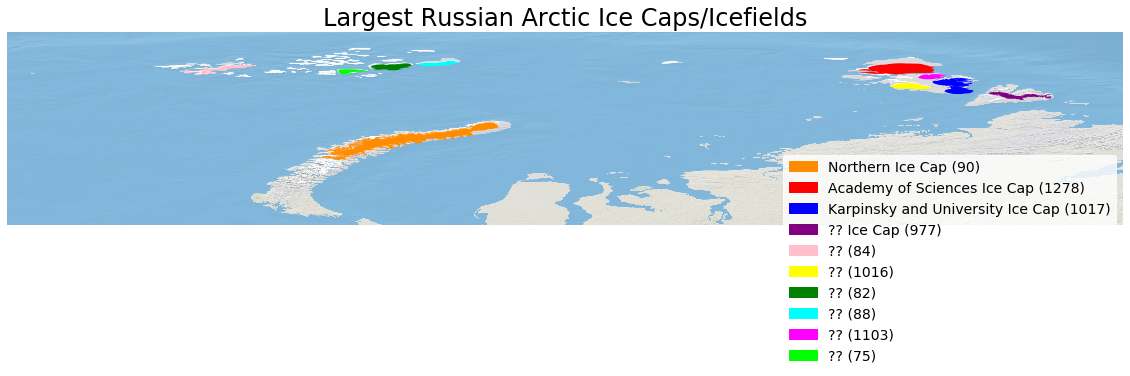

In [23]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Northern Ice Cap (90)', 'Academy of Sciences Ice Cap (1278)', 'Karpinsky and University Ice Cap (1017)', 
                 '?? Ice Cap (977)', '?? (84)', '?? (1016)', '?? (82)', 
                 '?? (88)', '?? (1103)', '?? (75)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.0, 0.4)) #, loc='upper left', borderaxespad=0.)

plt.show()

In [24]:
# Stop notebook and examine ice caps and icefields. 
# Comment this out when not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass

#print("Stopping notebook to examine glacier complexes.")
#raise StopExecution

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

Will need to split up Karpinsky and University Ice Caps since they are touching (Sharov, 2009).

### Clip Karpinsky Ice Cap from University Ice Cap

In [25]:
# Create a clipping polygon for Karpinsky Ice Cap
# Create dataframe that holds the clipping box
karp_area_points = Polygon([(100.5991, 79.9181), (99.0887, 79.9181),
                            (96.3089, 79.6414), (97.5284, 79.3001), 
                            (98.6435, 79.3367), (98.6984, 79.3001),
                            (100.5991, 79.2551), (100.5991, 79.9181)])

karp_gdf = gpd.GeoDataFrame([1],
                            geometry=[karp_area_points],
                            crs={'init': 'epsg:' + ic_epsg})

karp_ex_ic_df = cl.clip_shp(ice_caps_ex_df.iloc[2:3], karp_gdf)

In [26]:
karp_ex_ic_df

,id,area,geometry
2,1017,4054.455204,"(POLYGON ((98.3309954103443 79.32644292172773,..."


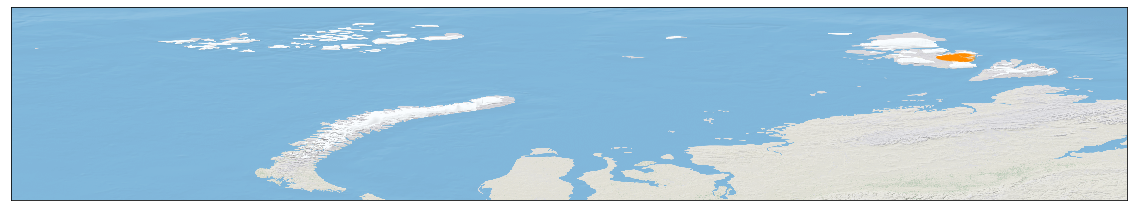

In [27]:
# plot to take a look
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
karp_ex_ic_df.plot(ax=ax, color="darkorange")

In [28]:
# Determine area of this clipped Karpinsky ice cap
karp_ex_area = karp_ex_ic_df['geometry'].to_crs({'init': 'epsg:' + ic_epsg}).area/10**6
round(karp_ex_area[2], 6)

2388.881108

### Set up Ice Cap data frame

In [29]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 8 rows because only interested in the top 2 ice caps and icefields
final_catchment_data_df.drop([2, 3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add Karpinsky dataframe and update its area measurement
final_catchment_data_df = final_catchment_data_df.append(karp_ex_ic_df.drop(['id'], axis=1))
final_catchment_data_df.iloc[2, final_catchment_data_df.columns.get_loc('area')] = round(karp_ex_area[2], 6)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [3, 3, 3]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Northern Ice Cap', 'Academy of Sciences Ice Cap', 'Karpinsky Ice Cap']

### Get ice catchment measurement dates from a range of glacier outline dates.

In [30]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [31]:
# Get glaciers on Northern Ice Cap
# This search takes a VERY long time (~20 minutes), so hard coding the date range here so don't have to run it again.
# The date range is 2004-07-19 to 2015-08-05
#north_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
#north_glaciers = glims_all_glaciers_df.loc[north_ic_mask]

# Print the minimum date and the maximum date
#north_glaciers_min_date = north_glaciers['src_date'].min()[0:10]
#north_glaciers_max_date = north_glaciers['src_date'].max()[0:10]
north_glaciers_min_date = '2004-07-19'
north_glaciers_max_date = '2015-08-05'
print('north start date: ' + north_glaciers_min_date)
print('north end date: ' + north_glaciers_max_date)
print('')

# Get glaciers on Academy of Sciences Ice Cap
acad_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
acad_glaciers = glims_all_glaciers_df.loc[acad_ic_mask]

# Print the minimum date and the maximum date
acad_glaciers_min_date = acad_glaciers['src_date'].min()[0:10]
acad_glaciers_max_date = acad_glaciers['src_date'].max()[0:10]
print('academy start date: ' + acad_glaciers_min_date)
print('academy end date: ' + acad_glaciers_max_date)
print('')

# Get glaciers on Karpinsky Ice Cap
karp_ic_mask = ws.pip(glims_all_glaciers_df, karp_ex_ic_df.iloc[0:1].reset_index(drop=True))
karp_glaciers = glims_all_glaciers_df.loc[karp_ic_mask]

# Print the minimum date and the maximum date
karp_glaciers_min_date = karp_glaciers['src_date'].min()[0:10]
karp_glaciers_max_date = karp_glaciers['src_date'].max()[0:10]
print('karpinsky start date: ' + karp_glaciers_min_date)
print('karpinsky end date: ' + karp_glaciers_max_date)
print('')

north start date: 2004-07-19
north end date: 2015-08-05

academy start date: 2006-07-13
academy end date: 2006-07-13

karpinsky start date: 2001-06-21
karpinsky end date: 2001-06-21



In [32]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [north_glaciers_min_date, acad_glaciers_min_date, karp_glaciers_min_date]

final_catchment_data_df['max_date'] = [north_glaciers_max_date, acad_glaciers_max_date, karp_glaciers_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 'min_date', 
                                                   'max_date', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [33]:
final_catchment_data_df

,region_no,reg_name,ic_name,primeclass,area_km2,min_date,max_date,geometry
0,9,Russian Arctic,Northern Ice Cap,3,21072.123177,2004-07-19,2015-08-05,"POLYGON ((56.918251 74.913927, 56.916186 74.91..."
1,9,Russian Arctic,Academy of Sciences Ice Cap,3,5583.439404,2006-07-13,2006-07-13,"POLYGON ((94.513183 80.150367, 94.504973000000..."
2,9,Russian Arctic,Karpinsky Ice Cap,3,2388.881108,2001-06-21,2001-06-21,"(POLYGON ((98.3309954103443 79.32644292172773,..."


### Plot the final catchment dataframe to verify it looks correct

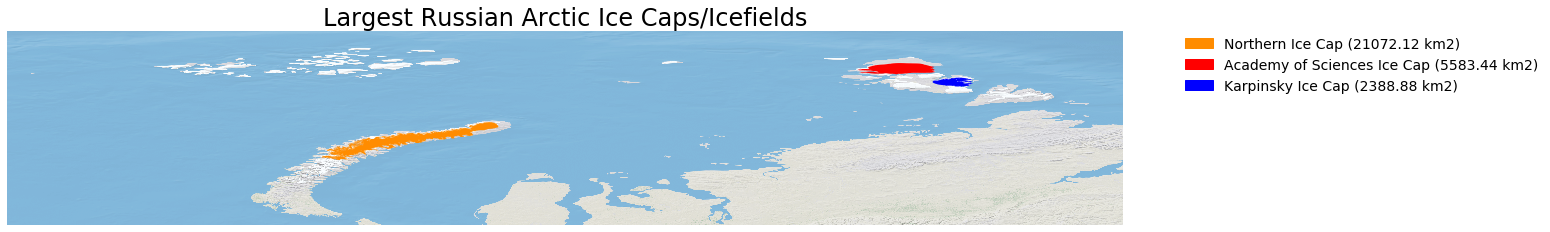

In [34]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [35]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-9-largest-complexes.zip
